# Plus TI

## Ingeniería de características para maximizar el monto salvado (mnt)

### Security Data Science

#### José Daniel Gómez Cabrera 21429


## Información básica del dataset


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [17]:
data = pd.read_csv("../data/dataset_feature_engineering.csv", header=0)

In [18]:
print("Información básica del dataset:")
print(f"Número de filas: {data.shape[0]}")
print(f"Número de columnas: {data.shape[1]}")
print("\nPrimeras 5 filas:")
print(data[['cc_num', 'merchant', 'category', 'amt', 'is_fraud']].head())

Información básica del dataset:
Número de filas: 1852394
Número de columnas: 35

Primeras 5 filas:
             cc_num                            merchant       category  \
0  2703186189652095          fraud_Rippin, Kub and Mann       misc_net   
1      630423337322     fraud_Heller, Gutmann and Zieme    grocery_pos   
2    38859492057661                fraud_Lind-Buckridge  entertainment   
3  3534093764340240  fraud_Kutch, Hermiston and Farrell  gas_transport   
4   375534208663984                 fraud_Keeling-Crist       misc_pos   

      amt  is_fraud  
0    4.97         0  
1  107.23         0  
2  220.11         0  
3   45.00         0  
4   41.96         0  


## Estadísticas descriptivas de la variable 'amt'


In [19]:
print("\nEstadísticas descriptivas de la variable 'amt':")
print(data['amt'].describe())


Estadísticas descriptivas de la variable 'amt':
count    1.852394e+06
mean     7.006357e+01
std      1.592540e+02
min      1.000000e+00
25%      9.640000e+00
50%      4.745000e+01
75%      8.310000e+01
max      2.894890e+04
Name: amt, dtype: float64


## Analizar la distribución de 'amt' en transacciones fraudulentas vs no fraudulentas


In [20]:
print("\nEstadísticas de 'amt' para transacciones fraudulentas vs no fraudulentas:")
print(data.groupby('is_fraud')['amt'].describe())


Estadísticas de 'amt' para transacciones fraudulentas vs no fraudulentas:
              count        mean         std   min      25%     50%      75%  \
is_fraud                                                                      
0         1842743.0   67.651278  153.548108  1.00    9.610   47.24   82.560   
1            9651.0  530.661412  391.028873  1.06  240.075  390.00  902.365   

               max  
is_fraud            
0         28948.90  
1          1376.04  


## Visualizar la distribución


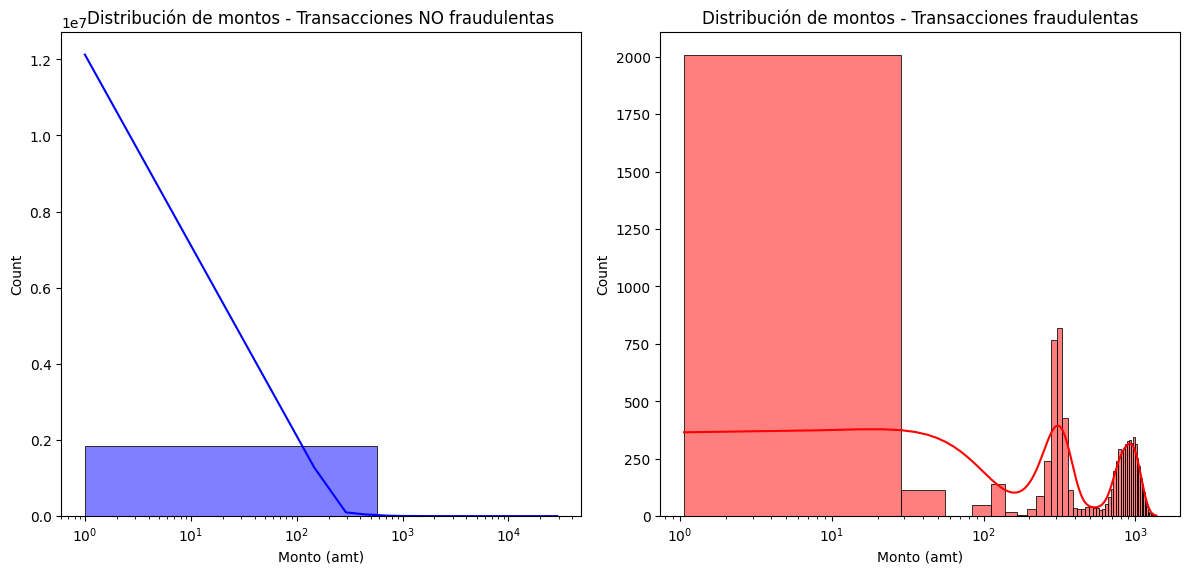

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data[data['is_fraud']==0]['amt'], kde=True, color='blue', bins=50)
plt.title('Distribución de montos - Transacciones NO fraudulentas')
plt.xlabel('Monto (amt)')
plt.xscale('log')  # Escala logarítmica para mejor visualización
plt.subplot(1, 2, 2)
sns.histplot(data[data['is_fraud']==1]['amt'], kde=True, color='red', bins=50)
plt.title('Distribución de montos - Transacciones fraudulentas')
plt.xlabel('Monto (amt)')
plt.xscale('log')  # Escala logarítmica para mejor visualización
plt.tight_layout()
plt.show()

# INGENIERÍA DE CARACTERÍSTICAS PARA LA VARIABLE AMT


## 1. Creación de características relacionadas con el dinero salvado


In [22]:
def create_amt_features(df):
    # Hacemos una copia para no modificar el original
    df_new = df.copy()
    
    # Características básicas
    df_new['amt_log'] = np.log1p(df_new['amt'])  # Log del monto (maneja montos de diferentes magnitudes)
    df_new['amt_sqrt'] = np.sqrt(df_new['amt'])  # Raíz cuadrada del monto
    
    # Categorización de montos
    df_new['amt_bin'] = pd.qcut(df_new['amt'], q=10, labels=False, duplicates='drop')
    
    # Detección de valores atípicos
    df_new['amt_zscore'] = stats.zscore(df_new['amt'])
    df_new['amt_is_outlier'] = (abs(df_new['amt_zscore']) > 3).astype(int)
    
    # Características relacionadas con el dinero salvado
    # 1. Potencial dinero salvado: monto de la transacción si es fraudulenta
    df_new['potential_saved_money'] = df_new['amt'] * df_new['is_fraud']
    
    # 2. Ratio del monto comparado con el promedio por categoría
    category_avg = df_new.groupby('category')['amt'].transform('mean')
    df_new['amt_to_category_avg_ratio'] = df_new['amt'] / category_avg
    
    # 3. Ratio del monto comparado con el promedio por comerciante
    merchant_avg = df_new.groupby('merchant')['amt'].transform('mean')
    df_new['amt_to_merchant_avg_ratio'] = df_new['amt'] / merchant_avg
    
    # 4. Delta respecto al promedio mensual del usuario
    user_month_avg = df_new.groupby(['cc_num', 'trans_month'])['amt'].transform('mean')
    df_new['amt_delta_from_user_monthly_avg'] = df_new['amt'] - user_month_avg
    
    # 5. Coeficiente de variación de montos por tarjeta
    user_std = df_new.groupby('cc_num')['amt'].transform('std')
    user_mean = df_new.groupby('cc_num')['amt'].transform('mean')
    df_new['amt_user_cv'] = user_std / user_mean
    df_new['amt_user_cv'].fillna(0, inplace=True)  # Para casos con una sola transacción
    
    # 6. Desviación porcentual del promedio de la categoría
    df_new['amt_pct_dev_from_category'] = ((df_new['amt'] - category_avg) / category_avg) * 100
    
    # 7. Características relacionadas con el tiempo
    # Monto por hora del día - identificar patrones temporales
    df_new['amt_per_hour'] = df_new.groupby('hour')['amt'].transform('mean')
    df_new['amt_hour_ratio'] = df_new['amt'] / df_new['amt_per_hour']
    
    # 8. Velocidad de gasto
    # Diferencia de tiempo entre transacciones del mismo usuario
    df_new = df_new.sort_values(['cc_num', 'unix_time'])
    df_new['prev_unix_time'] = df_new.groupby('cc_num')['unix_time'].shift(1)
    df_new['time_since_last_transaction'] = df_new['unix_time'] - df_new['prev_unix_time']
    df_new['spending_velocity'] = df_new['amt'] / df_new['time_since_last_transaction']
    df_new['spending_velocity'].fillna(0, inplace=True)  # Primera transacción
    
    # 9. Dinero potencialmente salvado si se detectan transacciones atípicas
    # Definimos atípicas como aquellas que exceden 2 desviaciones estándar
    df_new['saved_if_detected_outlier'] = np.where(
        (abs(df_new['amt_zscore']) > 2) & (df_new['is_fraud'] == 1),
        df_new['amt'],
        0
    )
    
    # 10. Creamos una característica que identifique transacciones en nuevos comerciantes
    # para el usuario que además son por montos inusuales
    df_new['new_merchant_unusual_amount'] = (
        (df_new['first_time_at_merchant'] == True) & 
        (abs(df_new['amt_zscore']) > 1.5)
    ).astype(int)
    
    # 11. Ratio de monto vs distancia (transacciones remotas de montos altos pueden ser sospechosas)
    # Evitamos división por cero
    df_new['amt_to_distance_ratio'] = df_new['amt'] / df_new['dist_between_client_and_merch'].replace(0, 0.1)
    
    # 12. Dinero salvado potencial en transacciones de alta velocidad y monto
    high_velocity_threshold = df_new['spending_velocity'].quantile(0.95)
    high_amount_threshold = df_new['amt'].quantile(0.95)
    
    df_new['high_velocity_high_amount'] = (
        (df_new['spending_velocity'] > high_velocity_threshold) & 
        (df_new['amt'] > high_amount_threshold)
    ).astype(int)
    
    df_new['potential_saved_high_risk'] = np.where(
        df_new['high_velocity_high_amount'] == 1,
        df_new['amt'] * df_new['is_fraud'],
        0
    )
    
    return df_new


## Crear las nuevas características


In [26]:
enriched_data = create_amt_features(data)

print("\nMuestra de las nuevas características creadas:")
amt_features = [col for col in enriched_data.columns if 'amt_' in col or 'saved' in col or 'potential' in col]
print(enriched_data[['amt', 'is_fraud'] + amt_features].head())

/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14800/3312527141.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new['amt_user_cv'].fillna(0, inplace=True)  # Para casos con una sola transacción
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_14800/3312527141.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obje


Muestra de las nuevas características creadas:
        amt  is_fraud  amt_month  amt_year  amt_month_shopping_net_spend  \
1017   7.27         0       7.27      7.27                           0.0   
2724  52.94         0      60.21     60.21                           0.0   
2726  82.08         0     142.29    142.29                           0.0   
2882  34.79         0     177.08    177.08                           0.0   
2907  27.18         0     204.26    204.26                           0.0   

       amt_log  amt_sqrt  amt_bin  amt_zscore  amt_is_outlier  ...  \
1017  2.112635  2.696294        1   -0.394298               0  ...   
2724  3.987872  7.275988        5   -0.107524               0  ...   
2726  4.419804  9.059801        7    0.075455               0  ...   
2882  3.577669  5.898305        4   -0.221493               0  ...   
2907  3.338613  5.213444        3   -0.269278               0  ...   

      amt_to_category_avg_ratio  amt_to_merchant_avg_ratio  \
1017        

## Análisis de las características relacionadas con el dinero salvado


In [27]:
print("\nEstadísticas de dinero potencialmente salvado:")
print(f"Total de dinero en transacciones fraudulentas: ${enriched_data[enriched_data['is_fraud']==1]['amt'].sum():.2f}")
print(f"Dinero potencialmente salvado con detección de valores atípicos: ${enriched_data['saved_if_detected_outlier'].sum():.2f}")
print(f"Dinero potencialmente salvado en transacciones de alto riesgo: ${enriched_data['potential_saved_high_risk'].sum():.2f}")


Estadísticas de dinero potencialmente salvado:
Total de dinero en transacciones fraudulentas: $5121413.29
Dinero potencialmente salvado con detección de valores atípicos: $4297906.19
Dinero potencialmente salvado en transacciones de alto riesgo: $3125982.71


## Ver la correlación entre las nuevas características y la variable objetivo (is_fraud)


In [29]:
print("\nCorrelación con is_fraud:")
correlation = enriched_data[['is_fraud'] + amt_features].corr()['is_fraud'].sort_values(ascending=False)
print(correlation)


Correlación con is_fraud:
is_fraud                           1.000000
potential_saved_money              0.804319
saved_if_detected_outlier          0.694929
potential_saved_high_risk          0.613965
amt_is_outlier                     0.347914
amt_to_merchant_avg_ratio          0.216102
amt_to_category_avg_ratio          0.212667
amt_pct_dev_from_category          0.212667
amt_sqrt                           0.211084
amt_zscore                         0.209308
amt_hour_ratio                     0.182635
amt_delta_from_user_monthly_avg    0.173399
amt_log                            0.114310
amt_month_shopping_net_spend       0.099671
amt_to_distance_ratio              0.084296
amt_bin                            0.076673
amt_per_hour                       0.067206
amt_month                          0.021675
amt_user_cv                       -0.011304
amt_year                          -0.031806
Name: is_fraud, dtype: float64


## Visualizar las características más importantes


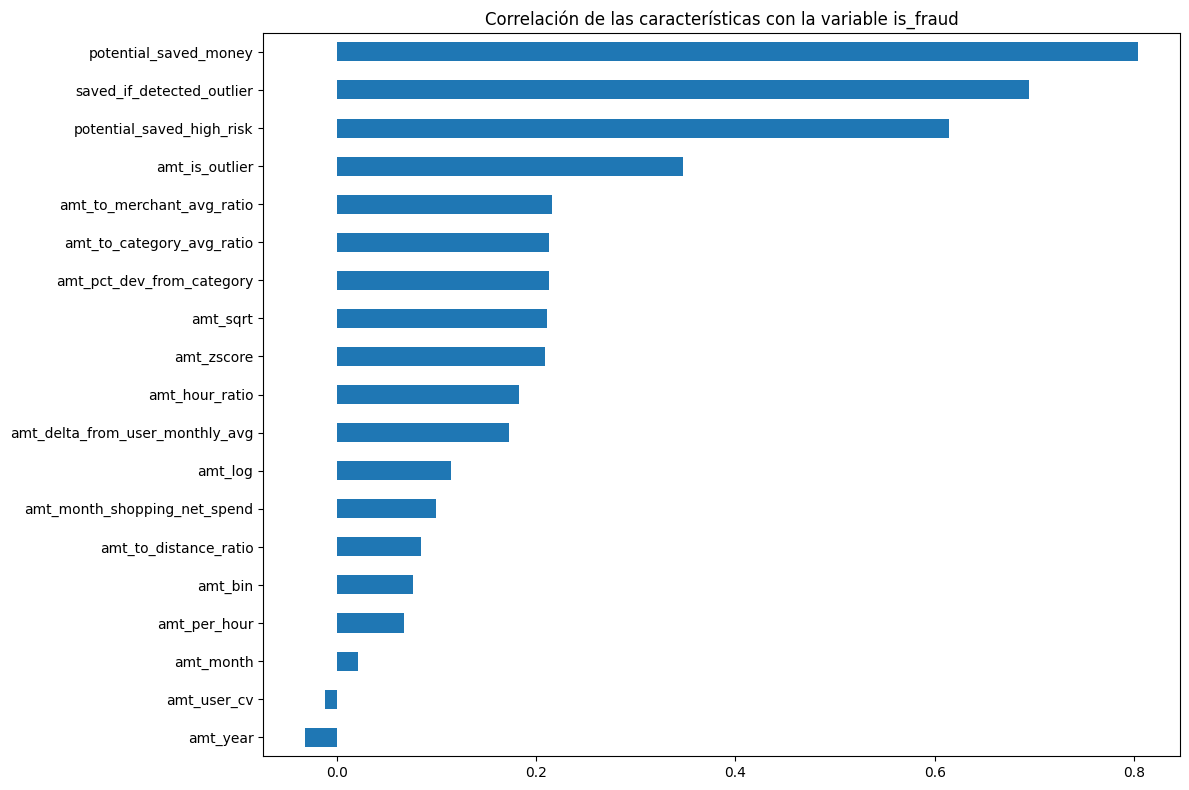

In [32]:
plt.figure(figsize=(12, 8))
correlation.drop('is_fraud').sort_values().plot(kind='barh')
plt.title('Correlación de las características con la variable is_fraud')
plt.tight_layout()
plt.show()

# Análisis de características más prometedoras para detectar fraudes y salvar dinero


In [33]:
top_features = correlation.drop('is_fraud').abs().sort_values(ascending=False).head(5).index

## Graficar las características más prometedoras


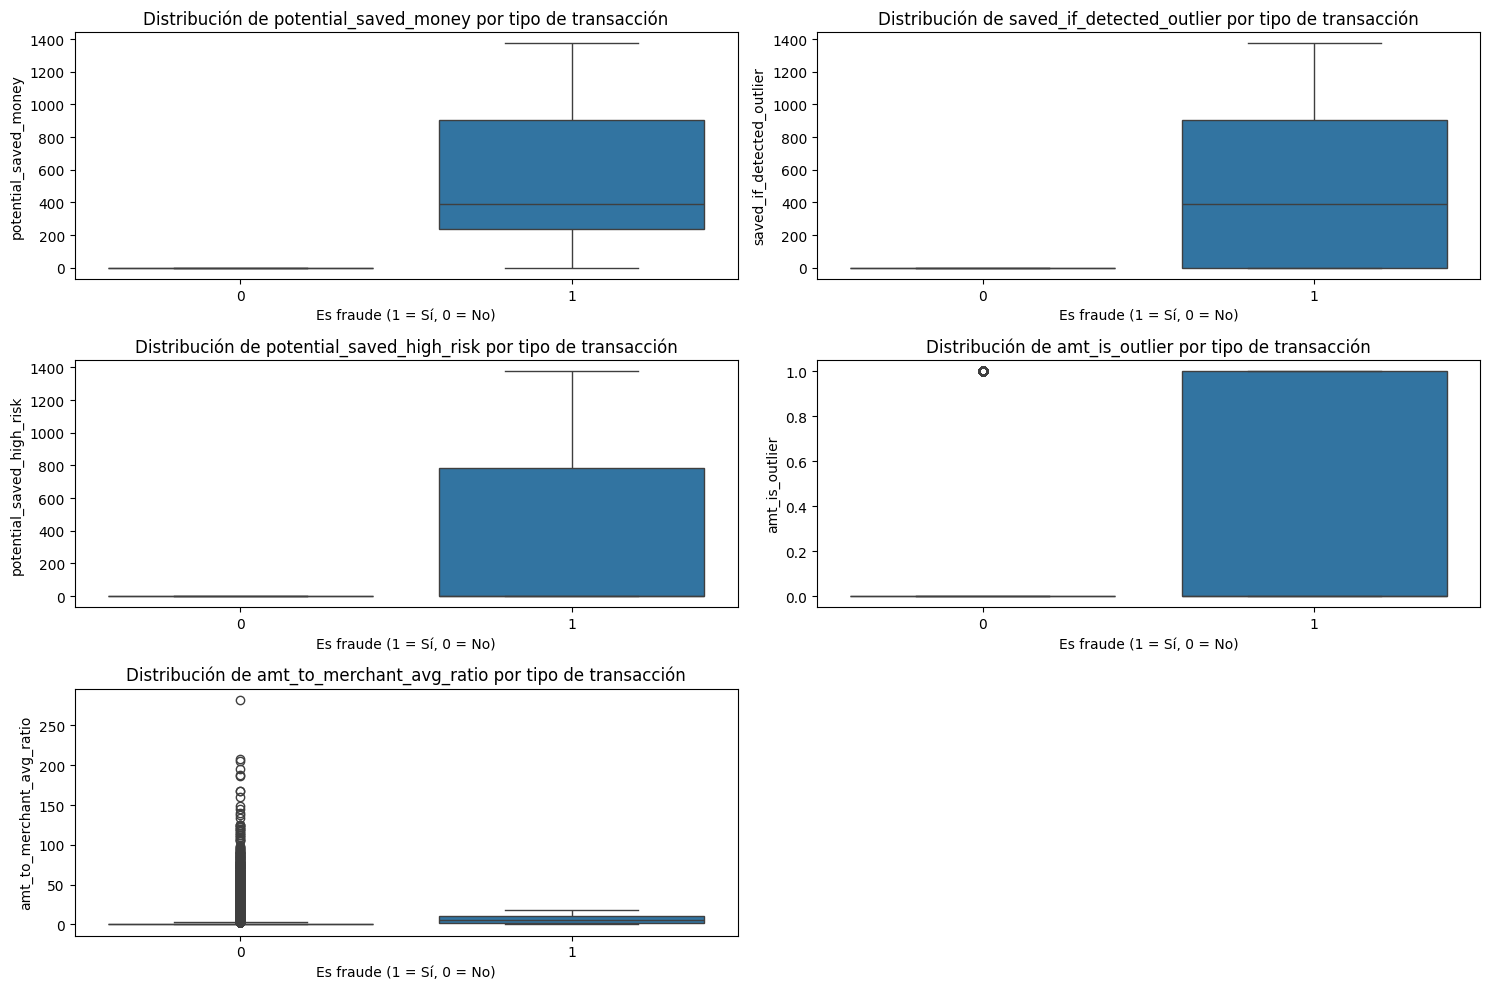

In [34]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x='is_fraud', y=feature, data=enriched_data)
    plt.title(f'Distribución de {feature} por tipo de transacción')
    plt.xlabel('Es fraude (1 = Sí, 0 = No)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

## Lo ideal es crear un DataFrame con las características más relevantes para el análisis de dinero salvado


In [35]:
print("\nCreando tabla final con características relevantes para análisis de dinero salvado...")
saved_money_features = [
    'cc_num', 'merchant', 'category', 'amt', 'is_fraud',
    'potential_saved_money', 'saved_if_detected_outlier', 'potential_saved_high_risk',
    'amt_zscore', 'amt_is_outlier', 'amt_to_category_avg_ratio', 
    'amt_delta_from_user_monthly_avg', 'new_merchant_unusual_amount',
    'high_velocity_high_amount', 'amt_to_distance_ratio'
]

saved_money_df = enriched_data[saved_money_features].copy()


Creando tabla final con características relevantes para análisis de dinero salvado...


## 5 primeras filas del DataFrame final


In [36]:
print("\nMuestra del DataFrame final con características para análisis de dinero salvado:")
print(saved_money_df.head())


Muestra del DataFrame final con características para análisis de dinero salvado:
           cc_num                           merchant       category    amt  \
1017  60416207185  fraud_Jones, Sawayn and Romaguera       misc_net   7.27   
2724  60416207185                    fraud_Berge LLC  gas_transport  52.94   
2726  60416207185                 fraud_Luettgen PLC  gas_transport  82.08   
2882  60416207185                fraud_Daugherty LLC      kids_pets  34.79   
2907  60416207185               fraud_Beier and Sons           home  27.18   

      is_fraud  potential_saved_money  saved_if_detected_outlier  \
1017         0                    0.0                        0.0   
2724         0                    0.0                        0.0   
2726         0                    0.0                        0.0   
2882         0                    0.0                        0.0   
2907         0                    0.0                        0.0   

      potential_saved_high_risk  amt_zsc

## Guardar el DataFrame con las nuevas características


In [37]:
saved_money_df.to_csv('../data/fraud_detection_amt_features.csv', index=False)

## Finalmente, la ingenieria de caracteristicas permitio obtener estos resultados


In [38]:
print(f"Número total de características creadas: {len(amt_features)}")
print(f"Características más prometedoras para detección de fraudes: {', '.join(top_features[:3])}")
print(f"Potencial dinero total salvado: ${enriched_data['potential_saved_money'].sum():.2f}")

Número total de características creadas: 19
Características más prometedoras para detección de fraudes: potential_saved_money, saved_if_detected_outlier, potential_saved_high_risk
Potencial dinero total salvado: $5121413.29
